# Homework 3 - Multilayer Perceptron and Cross-Validation

We introduced some linear models to do some simple regression and classification tasks. If our labels truly were related to the input data by a simple affine transformation, then this approach would be sufficient. However, linearity (in affine transformations) is a *strong* assumption.

Please implement the following functions and form a simple MLP!

## Hidden Layers
### Limitations of Linear Models

For example, linearity implies the *weaker* assumption of *monotonicity*, i.e.,
that any increase in our feature must
either always cause an increase in our model's output
(if the corresponding weight is positive),
or always cause a decrease in our model's output
(if the corresponding weight is negative).
Sometimes that makes sense.
For example, if we were trying to predict
whether an individual will repay a loan,
we might reasonably assume that all other things being equal,
an applicant with a higher income
would always be more likely to repay
than one with a lower income.
While monotonic, this relationship likely
is not linearly associated with the probability of
repayment. An increase in income from \$0 to \$50,000
likely corresponds to a bigger increase
in likelihood of repayment
than an increase from \$1 million to \$1.05 million.
One way to handle this might be to post-process our outcome
such that linearity becomes more plausible,
by using the logistic map (and thus the logarithm of the probability of outcome).

Note that we can easily come up with examples
that violate monotonicity.
Say for example that we want to predict health as a function
of body temperature.
For individuals with a body temperature
above 37°C (98.6°F),
higher temperatures indicate greater risk.
However, for individuals with body temperatures
below 37°C, lower temperatures indicate greater risk!
Again, we might resolve the problem
with some clever preprocessing, such as using the distance from 37°C
as a feature.

But what about classifying images of cats and dogs?
Should increasing the intensity
of the pixel at location (13, 17)
always increase (or always decrease)
the likelihood that the image depicts a dog?
Reliance on a linear model corresponds to the implicit
assumption that the only requirement
for differentiating cats vs. dogs is to assess
the brightness of individual pixels.
This approach is doomed to fail in a world
where inverting an image preserves the category.

And yet despite the apparent absurdity of linearity here,
as compared with our previous examples,
it is less obvious that we could address the problem
with a simple preprocessing fix.
That is, because the significance of any pixel
depends in complex ways on its context
(the values of the surrounding pixels).
While there might exist a representation of our data
that would take into account
the relevant interactions among our features,
on top of which a linear model would be suitable,
we simply do not know how to calculate it by hand.
With deep neural networks, we used observational data
to jointly learn both a representation via hidden layers
and a linear predictor that acts upon that representation.

We can overcome the limitations of linear models
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many fully connected layers on top of each other.
Each layer feeds into the layer above it,
until we generate outputs.
We can think of the first $L-1$ layers
as our representation and the final layer
as our linear predictor.
This architecture is commonly called
a *multilayer perceptron*,
often abbreviated as *MLP*, as shown below.

![An MLP with a hidden layer of 5 hidden units. ](./imgs/mlp.svg)

This MLP has 4 inputs, 3 outputs,
and its hidden layer contains 5 hidden units.
Since the input layer does not involve any calculations,
producing outputs with this network
requires implementing the computations
for both the hidden and output layers;
thus, the number of layers in this MLP is 2.
Note that both layers are fully connected.
Every input influences every neuron in the hidden layer,
and each of these in turn influences
every neuron in the output layer. Alas, we are not quite
done yet.

In [2]:
# import packages
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets as dataset
from torch.utils.data import DataLoader
from torchvision import transforms

### ReLU Function

The most popular choice,
due to both simplicity of implementation and
its good performance on a variety of predictive tasks,
is the *rectified linear unit* (*ReLU*).
[**ReLU provides a very simple nonlinear transformation**].
Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informally, the ReLU function retains only positive
elements and discards all negative elements
by setting the corresponding activations to 0.
To gain some intuition, we can plot the function.
As you can see, the activation function is piecewise linear.


In [29]:
# Tips: implement ReLU (Rectified Linear Unit) activation function
def relu(x):
    # to do
    return(max(x, 0))

In [4]:
print(relu(-1), relu(10))

0 10


### Sigmoid Function

[**The *sigmoid function* transforms its inputs**],
for which values lie in the domain $\mathbb{R}$,
(**to outputs that lie on the interval (0, 1).**)
For that reason, the sigmoid is
often called a *squashing function*:
it squashes any input in the range (-inf, inf)
to some value in the range (0, 1):

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
which either *fire* or *do not fire*.
Thus the pioneers of this field,
going all the way back to McCulloch and Pitts,
the inventors of the artificial neuron,
focused on thresholding units in 1943.
A thresholding activation takes value 0
when its input is below some threshold
and value 1 when the input exceeds the threshold.

When attention shifted to gradient based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable
approximation to a thresholding unit.
Sigmoids are still widely used as
activation functions on the output units,
when we want to interpret the outputs as probabilities
for binary classification problems: you can think of the sigmoid as a special case of the softmax.
However, the sigmoid has mostly been replaced
by the simpler and more easily trainable ReLU
for most use in hidden layers. Much of this has to do
with the fact that the sigmoid poses challenges for optimization
since its gradient vanishes for large positive *and* negative arguments.
This can lead to plateaus that are difficult to escape from.

Below, please implement a Sigmoid function:

In [5]:
# Tips: pls implement Sigmoid function
def sigmoid(x):
  # to do
  res = 1 / (1 + np.exp(-x))
  return res

In [5]:
# print(sigmoid(0))

0.5


### Tanh Function

Like the sigmoid function, [**the tanh (hyperbolic tangent)
function also squashes its inputs**],
transforming them into elements on the interval (**between -1 and 1**):

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function below. Note that as input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.


In [6]:
# Tips: pls implement Sigmoid function
def tanh(x):
    # to do
    res = (1 - np.exp(-2*x)) / (1 + np.exp(-2*x))
    return res

In [ ]:
# print(tanh(0) == 0, tanh(-100), tanh(100))

## Implementation from Scratch

Let's begin again by implementing a MLP from scratch.

### Initializing Model Parameters

We will use MNIST dataset (handwritten numbers), which contains 10 classes.
Each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

In [34]:
class MLP(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        super().__init__()
    
        # Tips: try to use nn.Sequential to implement two layer MLP with ReLU as activation function
        # to do
        # self.model = nn.Sequential(
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
        # self.params = [W1, b1, W2, b2]
        # nn.ReLU()

         
        # nn.Linear(784, num_hiddens),  #  hidden layer
        # nn.Linear(num_inputs, num_hiddens),  #  hidden layer
        # nn.ReLU(),
        # nn.Linear(num_hiddens, num_outputs),  # Output layer
        # x = x.reshape((-1, num_inputs))
        # )
    def relu(x):
        # to do
        return(max(x, 0))

    # Tips: forward function processes data througth model and return results
    def forward(self, x):
        # to do
        # self.model(x)
        x = x.reshape((-1, num_inputs))
        x = relu(x@self.W1 + self.b1)  # 这里“@”代表矩阵乘法
        return (x@self.W2 + self.b2)

Previously, we defined `forward` methods for models to transform input using the model parameters. These operations are essentially a pipeline: you take an input and apply a transformation (e.g., matrix multiplication with weights followed by bias addition), then repetitively use the output of the current transformation as input to the next transformation. However, you may have noticed that no `forward` method is defined here. In fact, `MLP` inherits the `forward` method from the `Module` class to  simply invoke `self.net(X)` (`X` is input), which is now defined as a sequence of transformations via the `Sequential` class. The `Sequential` class abstracts the forward process enabling us to focus on the transformations. We will further discuss how the `Sequential` class works in :numref.


### Training

[**The training loop**] is exactly the same as when we implemented softmax regression. This modularity enables us to separate matters concerning the model architecture from orthogonal considerations.

### Prepare Data and Cross Validation

Holdout sets are a great start to model validation. However, using a single train and test set if often not enough. Cross-validation is considered the gold standard when it comes to validating model performance and is almost always used when tuning model hyper-parameters.

In [31]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

# Prepare for training
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

### Visualize the Data

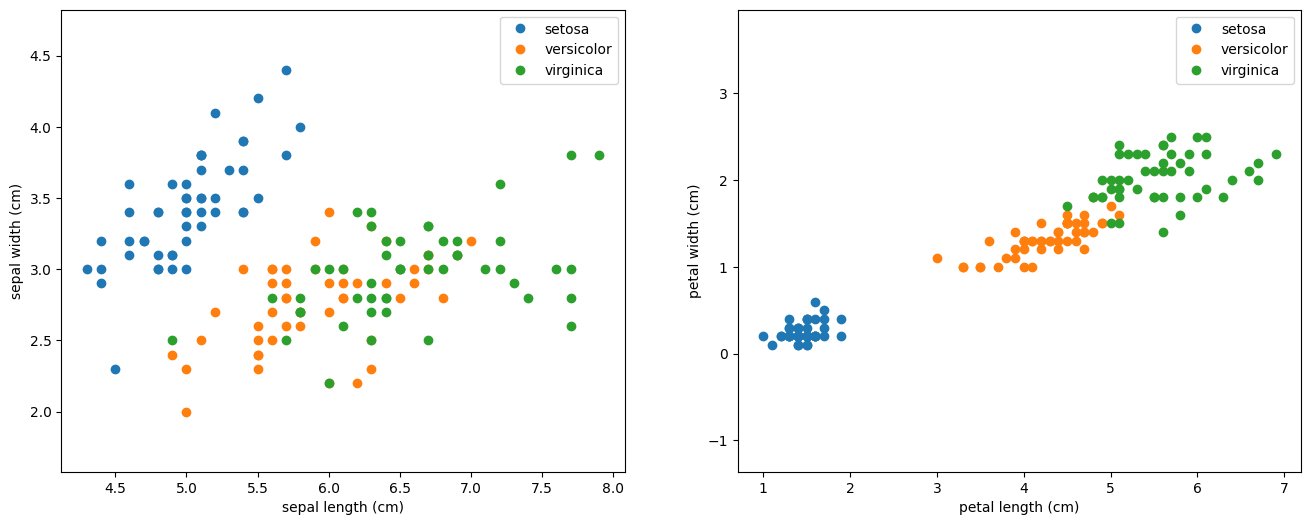

In [32]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
            linestyle='none', 
            marker='o', 
            label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend()

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
            linestyle='none', 
            marker='o', 
            label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend()

In [35]:
# Set fixed random number seed and hyperparameters
torch.manual_seed(2023)
learning_rate = 1e-3
batch_size = 128
epochs = 100

# Initialize the MLP
mlp = MLP(num_inputs=784, num_hiddens=256, num_outputs=10)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate) 

# Run the training loop
loss_list, acc_list = [], []
for epoch in range(0, epochs): # 5 epochs at maximum
    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Zero the gradients
    optimizer.zero_grad()
    
    # Perform forward pass
    outputs = mlp(X_train)
    
    # Compute loss
    loss = loss_function(outputs, y_train)
    
    # Perform backward pass
    loss.backward()
    
    # Perform optimization
    optimizer.step()
        
    # Print statistics
    loss_list.append(loss.item())
    acc_list.append(torch.sum(torch.argmax(outputs, axis=1) == y_train) / len(y_train))

    print('Training loss: %.3f, Training accuracy: %.3f' %
        (loss_list[epoch], acc_list[epoch] * 100))

    # test
    current_loss = 0.0
    current_acc = 0.0
    mlp.eval()
    with torch.no_grad():

        outputs = mlp(X_test)

        current_loss += loss.item()
        current_acc += torch.sum(torch.argmax(outputs, axis=1) == y_test) / len(y_test)


        print('Test loss: %.3f, Test accuracy: %.3f' %
            (current_loss, current_acc * 100))

    # Process is complete.
    print('Training process has finished.')

Starting epoch 1


NameError: name 'num_inputs' is not defined

### Plot Accuracy and Loss

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(acc_list)
ax1.set_ylabel("training accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("loss")
ax2.set_xlabel("epochs")

## Cross Validation

Holdout sets are a great start to model validation. However, using a single train and test set if often not enough. Cross-validation is considered the gold standard when it comes to validating model performance and is almost always used when tuning model hyper-parameters.

In [ ]:
# Load datasets and packages
from sklearn.datasets import load_diabetes 
import numpy as np
datasets = load_diabetes()
X, y = datasets['data'], datasets['target']

In [ ]:
# Split the training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Using the linear regression to fit the data
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train,y_train)
y_pred = reg.predict(X_test)
score = reg.score(X_test, y_test)
# In linear model, the score is referred to R^2 score
print(r'Score of the model is : {}'.format(score))

We have build a linear model by using training set and test set, now we use the cross-validation technique for training. 

In [ ]:
k = 5 # 5-fold cross-validation
n_samples = len(X_train)
fold_size = n_samples // k
scores = []
masks = []
models = []
for fold in range(k):
    reg = LinearRegression()
    
    # Tips: generate a boolean mask for the validation set in this fold
    val_mask = 
    
    # store the mask for visualization
    masks.append(val_mask)
    
    # create training and validation sets using this mask
    X_val, y_val = X_train[val_mask], y_train[val_mask]
    X_trn, y_trn = X_train[~val_mask], y_train[~val_mask]
    
    # fit the classifier
    
    # Tips: compute the score and record it
    score = 
    scores.append(score)
    models.append(reg)

1. Use the k models to predict the value of $y_{test}$ respectively, and calculate the score

In [ ]:
y_preds = []
score_tests = []

for fold in range(k):
    reg = models[fold]
    score_test =
    y_pred = 
    score_tests.append(score_test)
    y_preds.append(y_pred)
    
# Tips: calculate the mean score
score = 
print('Mean score of the {} model is : {}'.format(k, score))

2. Use the ensembled k models to predict $y_{test}$, and calculate the score

In [ ]:
y_preds = np.stack(y_preds, axis=0)
# Tips: calculate the mean prediction value
y_pred = 

from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred)
print('Score of the ensembled model by {} fold is : {}'.format(k, score))